# Intro

In [ ]:
import io
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
from google.colab import files
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from scipy.stats import chi2_contingency

In [ ]:
# Carregar o arquivo CSV
upload = files.upload()
file_name = list(upload.keys())[0]  # Pega o nome do primeiro arquivo
df_teste = pd.read_csv(io.BytesIO(upload[file_name]), encoding='utf-8')


Saving orders_combined_with_payments.csv to orders_combined_with_payments (4).csv


# Período que mais tem cancelamentos

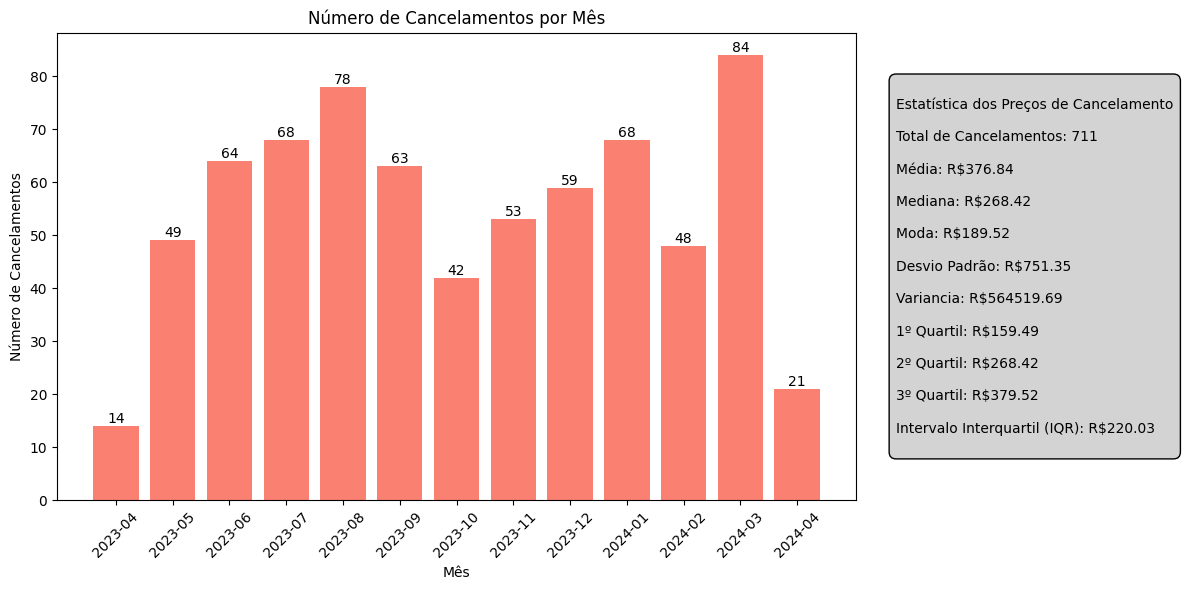

In [ ]:
# Filtra os pagamentos com status 'refunded' e faz uma cópia do DataFrame
df_cancelados = df_teste[df_teste['payments_status'] == 'refunded'].copy()

# Converte a coluna de data para datetime, removendo o fuso horário
df_cancelados['payments_date_last_modified'] = pd.to_datetime(df_cancelados['payments_date_last_modified']).dt.tz_localize(None)

# Agrupa por mês e conta o número de cancelamentos
df_cancelados['mês'] = df_cancelados['payments_date_last_modified'].dt.to_period('M')
cancelamentos_mensais = df_cancelados.groupby('mês').size()

# Análise Estatística dos Preços
preco_medio = df_cancelados['total_amount'].mean()
preco_mediana = df_cancelados['total_amount'].median()
preco_moda = df_cancelados['total_amount'].mode()[0]
desvio_padrao_preco = df_cancelados['total_amount'].std()
variancia_preco = df_cancelados['total_amount'].var()
quartis = df_cancelados['total_amount'].quantile([0.25, 0.5, 0.75])
iqr_preco = quartis[0.75] - quartis[0.25]

#----------------- Gráfico -----------------------------

# Plota o gráfico de cancelamentos por mês
fig, ax = plt.subplots(figsize=(12, 6))
barras = ax.bar(cancelamentos_mensais.index.astype(str), cancelamentos_mensais.values, color='salmon')

# Adiciona números de cancelamentos acima das barras
for barra in barras:
    yval = barra.get_height()
    ax.text(barra.get_x() + barra.get_width()/2.0, yval, int(yval), va='bottom', ha='center')

# Adiciona a análise estatística na lateral do gráfico
texto_estatisticas = f"""
Estatística dos Preços de Cancelamento
\nTotal de Cancelamentos: {df_cancelados.shape[0]}
\nMédia: R${preco_medio:.2f}
\nMediana: R${preco_mediana:.2f}
\nModa: R${preco_moda:.2f}
\nDesvio Padrão: R${desvio_padrao_preco:.2f}
\nVariancia: R${variancia_preco:.2f}
\n1º Quartil: R${quartis[0.25]:.2f}
\n2º Quartil: R${quartis[0.50]:.2f}
\n3º Quartil: R${quartis[0.75]:.2f}
\nIntervalo Interquartil (IQR): R${iqr_preco:.2f}
"""

# Adiciona o texto na lateral direita do gráfico
plt.gca().annotate(texto_estatisticas, xy=(1.05, 0.5), xycoords='axes fraction', fontsize=10, ha='left', va='center',
                   bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightgrey'))

ax.set_title('Número de Cancelamentos por Mês')
ax.set_xlabel('Mês')
ax.set_ylabel('Número de Cancelamentos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Análise Preço x Cancelamento

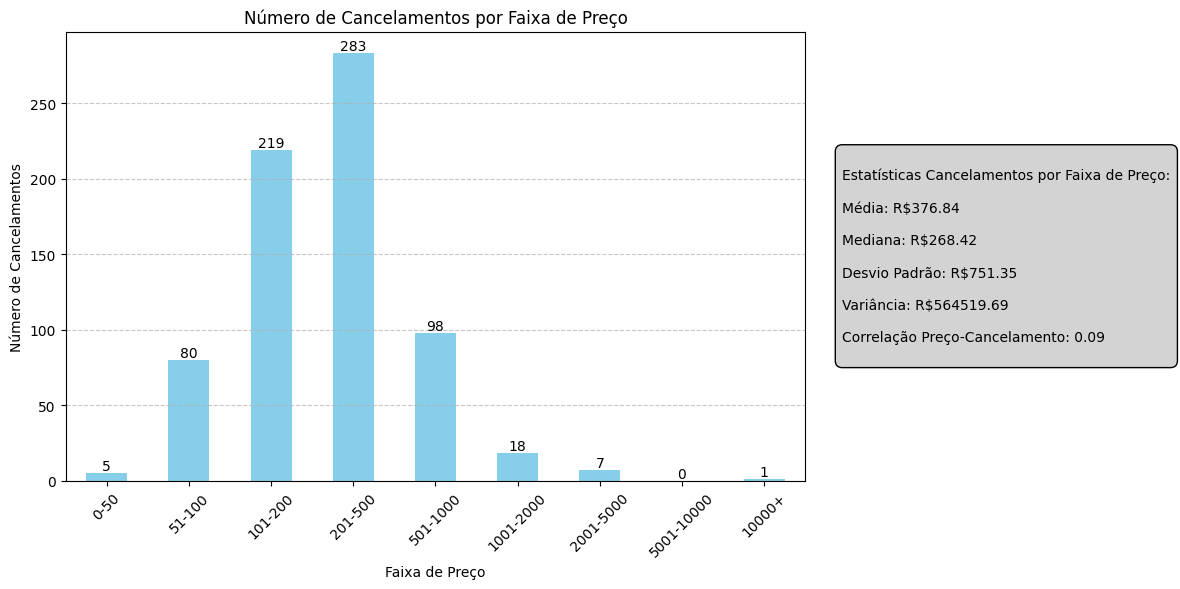

In [ ]:
# Codificar a coluna 'payments_status' para obter a coluna 'is_refunded'
df_teste['is_refunded'] = df_teste['payments_status'].apply(lambda x: 1 if x == 'refunded' else 0)

# Filtrar os pagamentos com status 'refunded' e fazer uma cópia do DataFrame
df_cancelados = df_teste[df_teste['payments_status'] == 'refunded'].copy()

# Definir as faixas de preço
faixas = [0, 50, 100, 200, 500, 1000, 2000, 5000, 10000, df_cancelados['total_amount'].max()]
rotulos = ['0-50', '51-100', '101-200', '201-500', '501-1000', '1001-2000', '2001-5000', '5001-10000', '10000+']

# Criar uma nova coluna para as faixas de preço
df_cancelados['faixa_preço'] = pd.cut(df_cancelados['total_amount'], bins=faixas, labels=rotulos)

# Contar o número de cancelamentos em cada faixa de preço
cancelamentos_por_faixa = df_cancelados['faixa_preço'].value_counts().sort_index()

# Estatísticas descritivas
preco_medio = df_cancelados['total_amount'].mean()
preco_mediana = df_cancelados['total_amount'].median()
desvio_padrao = df_cancelados['total_amount'].std()
variancia = df_cancelados['total_amount'].var()
correlacao = df_teste[['total_amount', 'is_refunded']].corr().iloc[0, 1]

# Preparar o texto das estatísticas descritivas
texto_estatisticas = f"""
Estatísticas Cancelamentos por Faixa de Preço:\n
Média: R${preco_medio:.2f}\n
Mediana: R${preco_mediana:.2f}\n
Desvio Padrão: R${desvio_padrao:.2f}\n
Variância: R${variancia:.2f}\n
Correlação Preço-Cancelamento: {correlacao:.2f}
"""

# Plotar o gráfico de cancelamentos por faixa de preço
plt.figure(figsize=(12,6))
barras = cancelamentos_por_faixa.plot(kind='bar', color='skyblue')

# Adicionar o número de cancelamentos acima de cada barra
for barra in barras.patches:
    altura = barra.get_height()
    barras.text(barra.get_x() + barra.get_width() / 2, altura, int(altura),
                ha='center', va='bottom', fontsize=10, color='black')

# Adicionar o texto das estatísticas descritivas
plt.gca().annotate(texto_estatisticas, xy=(1.05, 0.5), xycoords='axes fraction', fontsize=10, ha='left', va='center',
                   bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightgrey'))

plt.title('Número de Cancelamentos por Faixa de Preço')
plt.xlabel('Faixa de Preço')
plt.ylabel('Número de Cancelamentos')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Análise Cancelamento x Forma de Pagamento

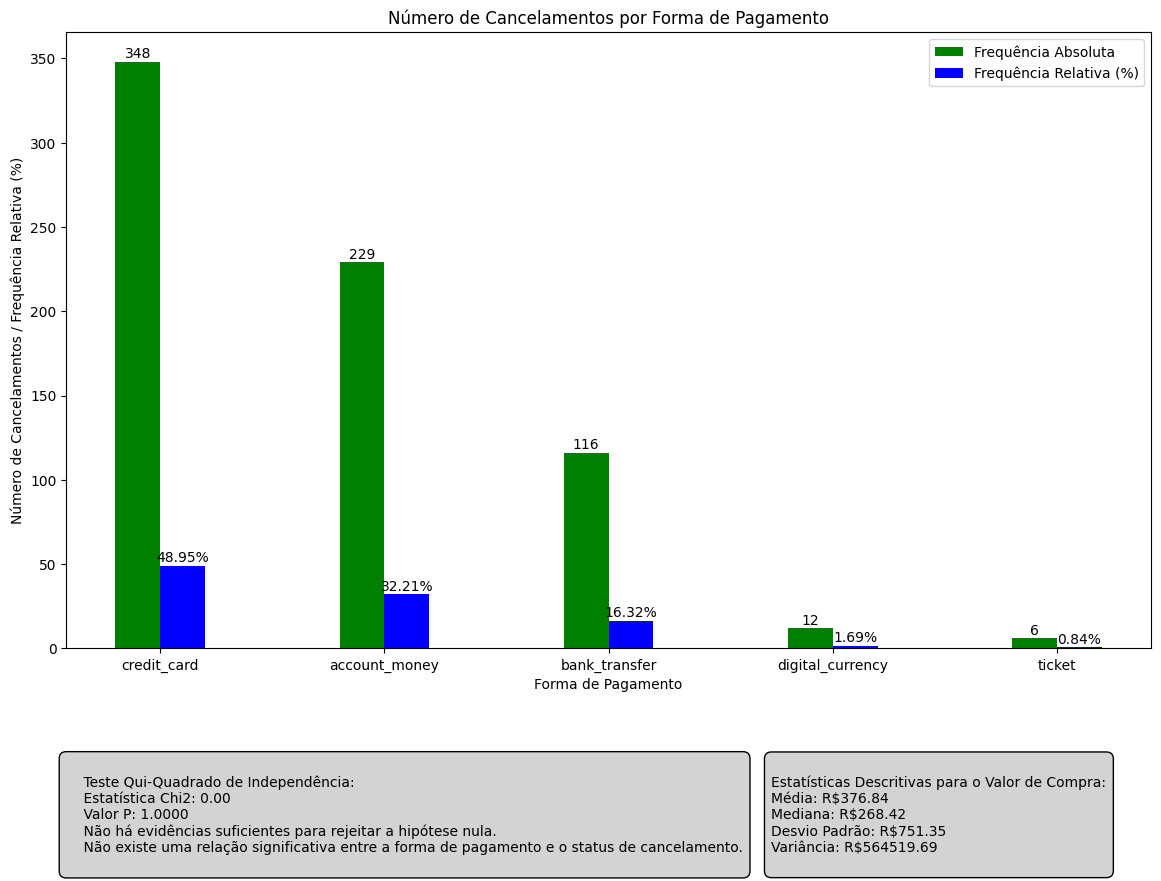

In [ ]:
# Estatísticas Descritivas
preço_medio = df_cancelados['total_amount'].mean()
preco_mediana = df_cancelados['total_amount'].median()
desvio_padrao = df_cancelados['total_amount'].std()
variancia = df_cancelados['total_amount'].var()

# Texto das Estatísticas Descritivas
stats_text = f"""
Estatísticas Descritivas para o Valor de Compra:
Média: R${preço_medio:.2f}
Mediana: R${preco_mediana:.2f}
Desvio Padrão: R${desvio_padrao:.2f}
Variância: R${variancia:.2f}
"""

# Filtra os pagamentos com status 'refunded' e faz uma cópia do DataFrame
df_reembolsado = df_teste[df_teste['payments_status'] == 'refunded'].copy()

# Número de Cancelamentos por Forma de Pagamento
cancelamentos_por_pagamento = df_reembolsado['payments_payment_type'].value_counts()
cancelamentos_percentual = cancelamentos_por_pagamento / cancelamentos_por_pagamento.sum() * 100

# Configuração do Gráfico
largura = 0.2  # Largura das barras
x = np.arange(len(cancelamentos_por_pagamento))  # Localização das barras

plt.figure(figsize=(14,8))
plt.bar(x - largura/2, cancelamentos_por_pagamento, largura, color='green', label='Frequência Absoluta')
plt.bar(x + largura/2, cancelamentos_percentual, largura, color='blue', label='Frequência Relativa (%)')

# Adicionar rótulos às barras
for i in range(len(cancelamentos_por_pagamento)):
    plt.text(x[i] - largura/2, cancelamentos_por_pagamento.iloc[i] + 0.5, f'{cancelamentos_por_pagamento.iloc[i]}', ha='center', va='bottom', color='black')
    plt.text(x[i] + largura/2, cancelamentos_percentual.iloc[i] + 0.5, f'{cancelamentos_percentual.iloc[i]:.2f}%', ha='center', va='bottom', color='black')

# Configuração dos rótulos e títulos
plt.title('Número de Cancelamentos por Forma de Pagamento')
plt.xlabel('Forma de Pagamento')
plt.ylabel('Número de Cancelamentos / Frequência Relativa (%)')
plt.xticks(x, cancelamentos_por_pagamento.index, rotation=0)
plt.legend(loc='upper right')

# Teste Qui-Quadrado de Independência
tabela_contingencia = pd.crosstab(df_reembolsado['payments_payment_type'], df_reembolsado['payments_status'])
estat_chi2, valor_p, graus_liberdade, esperados = chi2_contingency(tabela_contingencia)

# Texto do Teste Qui-Quadrado
if valor_p < 0.05:
    texto_chi2 = f"""
    Teste Qui-Quadrado de Independência:
    Estatística Chi2: {estat_chi2:.2f}
    Valor P: {valor_p:.4f}
    \nHá evidências suficientes para rejeitar a hipótese nula.
    Existe uma relação significativa entre a forma de pagamento e o status de cancelamento.
    """
else:
    texto_chi2 = f"""
    Teste Qui-Quadrado de Independência:
    Estatística Chi2: {estat_chi2:.2f}
    Valor P: {valor_p:.4f}
    Não há evidências suficientes para rejeitar a hipótese nula.
    Não existe uma relação significativa entre a forma de pagamento e o status de cancelamento.
    """

# Adicionar as legendas laterais ao gráfico
plt.gca().annotate(texto_chi2, xy=(0, -0.27), xycoords='axes fraction', fontsize=10, ha='left', va='center',
                   bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightgrey'))

plt.gca().annotate(stats_text, xy=(0.65, -0.27), xycoords='axes fraction', fontsize=10, ha='left', va='center',
                   bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightgrey'))

# Exibir o gráfico
plt.show()

# Análise de quantidade de Cancelamentos

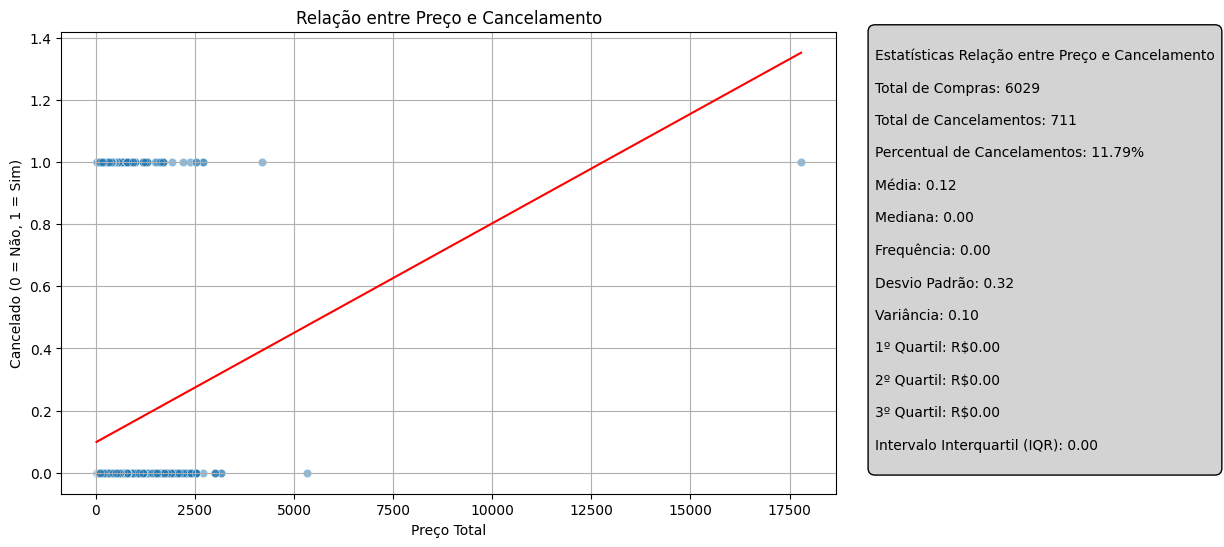

                            OLS Regression Results                            
Dep. Variable:            is_refunded   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     44.15
Date:                Fri, 16 Aug 2024   Prob (F-statistic):           3.31e-11
Time:                        02:40:25   Log-Likelihood:                -1710.5
No. Observations:                6029   AIC:                             3425.
Df Residuals:                    6027   BIC:                             3438.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0978      0.005     19.058   

In [ ]:
# Filtra os pagamentos com status 'refunded' e faz uma cópia do DataFrame
df_refunded = df_teste[df_teste['payments_status'] == 'refunded'].copy()

# Total de Compras
total_purchases = df_teste.shape[0]

# Total de Cancelamentos
total_cancelamentos = df_refunded.shape[0]

# Ajustando o modelo de regressão
modelo = ols('is_refunded ~ total_amount', data=df_teste).fit()

# Calculando estatísticas
media_cancelamentos = df_teste['is_refunded'].mean()
mediana_cancelamentos = df_teste['is_refunded'].median()
moda_cancelamentos = df_teste['is_refunded'].mode()[0]
desvio_padrao_cancelamentos = df_teste['is_refunded'].std()
variancia_cancelamentos = df_teste['is_refunded'].var()
quartis_cancelamentos = df_teste['is_refunded'].quantile([0.25, 0.5, 0.75])
iqr_cancelamentos = quartis_cancelamentos[0.75] - quartis_cancelamentos[0.25]

percentual_cancelado = (total_cancelamentos / total_purchases) * 100

# Plotando a regressão
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_teste['total_amount'], y=df_teste['is_refunded'], alpha=0.5)
sns.lineplot(x=df_teste['total_amount'], y=modelo.fittedvalues, color='red')
plt.title('Relação entre Preço e Cancelamento')
plt.xlabel('Preço Total')
plt.ylabel('Cancelado (0 = Não, 1 = Sim)')
plt.grid(True)

# Anotando o gráfico
texto_estatisticas = f"""
Estatísticas Relação entre Preço e Cancelamento
\nTotal de Compras: {total_purchases}
\nTotal de Cancelamentos: {total_cancelamentos}
\nPercentual de Cancelamentos: {percentual_cancelado:.2f}%
\nMédia: {media_cancelamentos:.2f}
\nMediana: {mediana_cancelamentos:.2f}
\nFrequência: {moda_cancelamentos:.2f}
\nDesvio Padrão: {desvio_padrao_cancelamentos:.2f}
\nVariância: {variancia_cancelamentos:.2f}
\n1º Quartil: R${quartis_cancelamentos[0.25]:.2f}
\n2º Quartil: R${quartis_cancelamentos[0.5]:.2f}
\n3º Quartil: R${quartis_cancelamentos[0.75]:.2f}
\nIntervalo Interquartil (IQR): {iqr_cancelamentos:.2f}
"""

plt.gca().annotate(texto_estatisticas, xy=(1.05, 1), xycoords='axes fraction', fontsize=10, ha='left', va='top',
                   bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightgrey'))

plt.show()

# Visualizando os resultados
print(modelo.summary())

# Tipo de produto x cancelamento

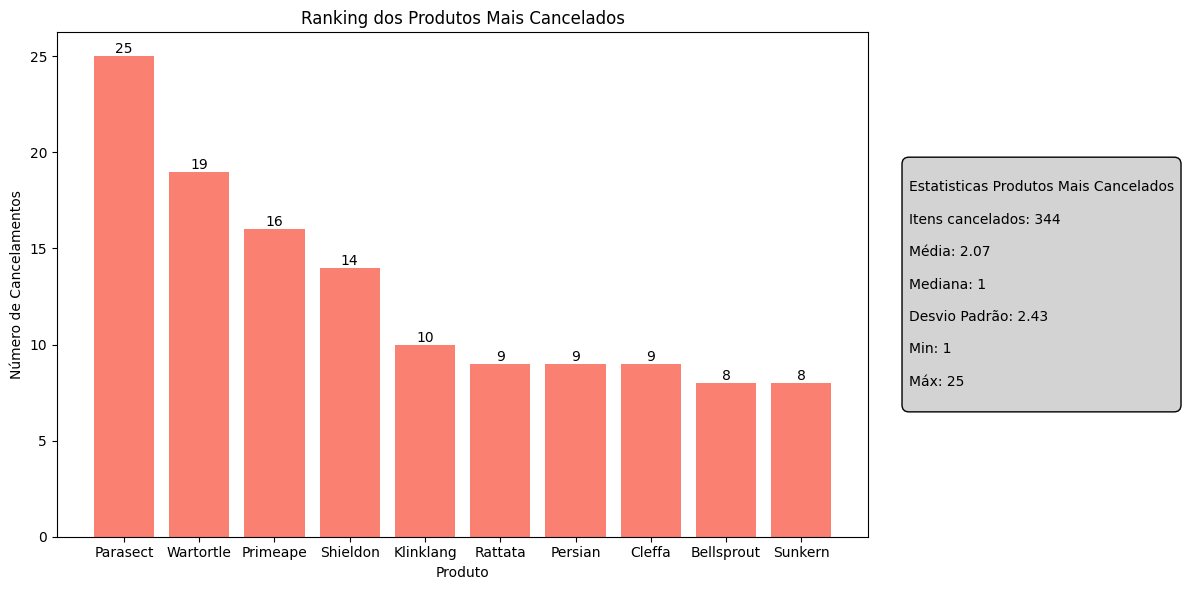

In [ ]:
# Função para extrair os dados de produtos do CSV
def extrair_itens_pedido(itens_pedido):
    itens = []
    try:
        lista_itens = ast.literal_eval(itens_pedido)
        for item in lista_itens:
            produto = item.get('item', {})
            itens.append({
                'Produto': produto.get('title', 'Desconhecido'),
                'Quantidade': item.get('quantity', 0),
                'Preço Unitário': item.get('unit_price', 0),
                'Categoria': produto.get('category_id', 'Desconhecido'),
                'Tipo de Anuncio': item.get('listing_type_id', 'Desconhecido')
            })
    except Exception as e:
        print(f"Erro ao processar itens do pedido: {e}")
    return itens

# Aplicar a função para extrair todos os produtos com seus preços
df_teste['itens_extraídos_com_preço'] = df_teste['order_items'].apply(extrair_itens_pedido)

# Filtrar apenas os pagamentos com status 'refunded'
df_reembolsado = df_teste[df_teste['payments_status'] == 'refunded'].copy()

# Criar uma lista de dicionários com produtos, quantidades e preços
lista_itens = []
for itens in df_reembolsado['itens_extraídos_com_preço']:
    for item in itens:
        lista_itens.append(item)  # Ajustado para não usar índices

# Criar um DataFrame a partir da lista de dicionários
itens_df = pd.DataFrame(lista_itens)

# Contar a quantidade de cancelamentos para cada produto
ranking_df = itens_df.groupby('Produto').size().reset_index(name='Número de Cancelamentos')

# Classificar os produtos com base no número de cancelamentos em ordem decrescente
ranking_df = ranking_df.sort_values(by='Número de Cancelamentos', ascending=False)

# Plotar o gráfico de barras
plt.figure(figsize=(12, 6))
barras = plt.bar(ranking_df['Produto'].head(10), ranking_df['Número de Cancelamentos'].head(10), color='salmon')

# Adicionar números de cancelamentos acima das barras
for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2.0, yval, int(yval), va='bottom', ha='center')

# Adicionar Estatísticas Descritivas
estatisticas = ranking_df['Número de Cancelamentos'].describe()

texto_estatisticas = f"""
Estatisticas Produtos Mais Cancelados\n
Itens cancelados: {int(estatisticas['count'])}\n
Média: {estatisticas['mean']:.2f}\n
Mediana: {int(estatisticas['50%'])}\n
Desvio Padrão: {estatisticas['std']:.2f}\n
Min: {int(estatisticas['min'])}\n
Máx: {int(estatisticas['max'])}
"""

plt.gca().annotate(texto_estatisticas, xy=(1.05, 0.5), xycoords='axes fraction', fontsize=10, ha='left', va='center',
                   bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightgrey'))

plt.title('Ranking dos Produtos Mais Cancelados')
plt.xlabel('Produto')
plt.ylabel('Número de Cancelamentos')
plt.xticks(rotation=0, ha='center')
plt.tight_layout()
plt.show()